# Saffman, M., et al. "Symmetric Rydberg controlled-Z gates with adiabatic pulses." Physical Review A 101.6 (2020): 062309.

In [1]:
%cd /home/thc/Ubuntu_data/IAMS-Rydberg-atom-quantum-computing

/home/thc/Ubuntu_data/IAMS-Rydberg-atom-quantum-computing


In [2]:
from IPython.display import clear_output

from qutip import *
import math

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from rdquantum.pulse_shape import Saffman_shape
from rdquantum.fidelity import fidelity
from rdquantum.optimizer.de import de

# Physical system

In [3]:
### Hamiltonian ###
def Hamiltonian(shape_omega1, shape_omega2, shape_delta1):
    rho = []    # 0, 1, p, r, d
    for i in range(5):
        rho.append(ket2dm(basis(5,i)))

    I = qeye(5)

    H_omega1 = np.zeros((5,5))
    H_omega1[2][1] = 2*np.pi / 2
    H_omega1[1][2] = 2*np.pi / 2
    H_omega1 = Qobj(H_omega1)

    H_omega2 = np.zeros((5,5))
    H_omega2[3][2] = 2*np.pi / 2
    H_omega2[2][3] = 2*np.pi / 2
    H_omega2 = Qobj(H_omega2)

    H_delta1 = np.zeros((5,5))
    H_delta1[2][2] = 2*np.pi
    H_delta1 = Qobj(H_delta1)

    B = 2*np.pi * 500           # (MHz) Strength of Rydberg states interaction
    Brr = np.zeros((5,5))
    Brr[3][3] = np.sqrt(B)
    Brr = tensor(Qobj(Brr), Qobj(Brr))

    H = [[tensor(H_omega1, I) + tensor(I, H_omega1), shape_omega1], [tensor(H_omega2, I) + tensor(I, H_omega2), shape_omega2], 
        [tensor(H_delta1, I) + tensor(I, H_delta1), shape_delta1], [Brr, '1']]

    return H


### Pulse shape omega1(t), omega2(t) and delta1(t) ###
def PulseShape(times, Pulses, T_gate, n_seg):

    def shape_omega1(t, arg):
        return Saffman_shape(t, Pulses['Omega1'],T_gate, n_seg)

    def shape_omega2(t, arg):
        return Saffman_shape(t, Pulses['Omega2'], T_gate, n_seg)

    # Shape of detunning delta1(t)
    def shape_delta1(t, arg):
        return Saffman_shape(t, Pulses['Delta1'], T_gate, n_seg)
    
    return shape_omega1, shape_omega2, shape_delta1


### Decay term, c_ops ###
def Decay(gammap=1/0.155, gammar=1/540):
    # gammap: (1/mu s) population decay rate of the Rydberg state
    # gammar: (1/mu s) population decay rate of the P state
    c_ops = []
    I = qeye(5)

    L0p = np.zeros((5,5))
    L0p[0][2] = np.sqrt(1/16 * gammap)
    c_ops.append(tensor(Qobj(L0p), I))
    c_ops.append(tensor(I, Qobj(L0p)))

    L0r = np.zeros((5,5))
    L0r[0][3] = np.sqrt(1/32 * gammar)
    c_ops.append(tensor(Qobj(L0r), I))
    c_ops.append(tensor(I, Qobj(L0r)))

    L1p = np.zeros((5,5))
    L1p[1][2] = np.sqrt(1/16 * gammap)
    c_ops.append(tensor(Qobj(L1p), I))
    c_ops.append(tensor(I, Qobj(L1p)))

    L1r = np.zeros((5,5))
    L1r[1][3] = np.sqrt(1/32 * gammar)
    c_ops.append(tensor(Qobj(L1r), I))
    c_ops.append(tensor(I, Qobj(L1r)))

    Ldp = np.zeros((5,5))
    Ldp[4][2] = np.sqrt(7/8 * gammap)
    c_ops.append(tensor(Qobj(Ldp), I))
    c_ops.append(tensor(I, Qobj(Ldp)))

    Ldr = np.zeros((5,5))
    Ldr[4][3] = np.sqrt(7/16 * gammar)
    c_ops.append(tensor(Qobj(Ldr), I))
    c_ops.append(tensor(I, Qobj(Ldr)))

    Lpr = np.zeros((5,5))
    Lpr[2][3] = np.sqrt(1/2 * gammar)
    c_ops.append(tensor(Qobj(Lpr), I))
    c_ops.append(tensor(I, Qobj(Lpr)))

    return c_ops


### Create two qubits state as density matrix, dm(control_qubit, target_qubit) ###
# def dm(control_qubit, target_qubit):
#     return ket2dm( tensor(basis(5, control_qubit), basis(5, target_qubit)) )

# Gate Operation

In [4]:
# Gate operation
def GateOp(Pulses, rho_init, targets):
    times = np.linspace(0.0, 1, 100)
    T_gate = 1              # (mu s) Total gate time
    n_seg = 2*len(Omega1)   # Number of segments

    shape_omega1, shape_omega2, shape_delta1 = PulseShape(times, Pulses, T_gate, n_seg)
    H = Hamiltonian(shape_omega1, shape_omega2, shape_delta1)
    c_ops = Decay(1/0.155, 1/540)
    
    results = mesolve(H, rho_init, times, c_ops, targets, options=Options(nsteps=10000))
    return results

# Outpout

In [7]:
Omega1 = [1.38, 10.30, 25.54, 42.85, 82.50, 93.35]
Omega2 = [165.09, 199.99, 198.14, 198.87, 200.00, 173.48]
Delta1 = [392.57, 363.48, 364.36, 360.99, 416.45, 420.39]
Pulses = {'Omega1': Omega1, 'Omega2': Omega2, 'Delta1': Delta1}
PulsesRange = {'Omega1': [-100, 100], 'Omega2': [150, 200], 'Delta1': [360, 425]}

Had = np.zeros((5,5))
Had[0][0] = 1
Had[0][1] = 1
Had[1][0] = 1
Had[1][1] = -1

I = qeye(5)
Had = Qobj(Had/np.sqrt(2))

ket00 = tensor(basis(5,0), basis(5,0))
ket01 = tensor(basis(5,0), basis(5,1))
ket10 = tensor(basis(5,1), basis(5,0))
ket11 = tensor(basis(5,1), basis(5,1))

# Target Bell state, rho_bell = 1/sqrt(2) * (|01> + |10>)
rho0101 = tensor(I, Had) * ket2dm(ket01) * tensor(I, Had)
rho1010 = tensor(I, Had) * ket2dm(ket10) * tensor(I, Had)
rho0110 = tensor(I, Had) * (ket10 * ket01.dag()) * tensor(I, Had)
rho_bell = [rho0101, rho1010, rho0110]

# Initial state, rhoi = |01><01|
rhoi = tensor(Had, Had) * ket2dm(ket01) * tensor(Had, Had)

bell_fidelity = fidelity(GateOp)
print(bell_fidelity.get_fidelity(Pulses, rhoi, rho_bell))

0.9974886842583736


# Differentail Evolution

In [8]:
K = len(Pulses)
# diffevo = de(bell_fidelity, K, 0, 500)
diffevo = de(bell_fidelity, rhoi, rho_bell)
diffevo.createPopulations(Pulses, PulsesRange)
diffevo.start(itr=2, batch=10)

Number of control parameters: 18
Populations size: 270
Start differential evolution...
Iterations: 2
Optimized fidelity: 0.3739264113246564
# 2 batch iteration.

Fidelity (Ci, Di) = 0.874345807473399 0.7029781070832442, replace population 122
Fidelity (Ci, Di) = 0.8658269799883002 0.4666426104760717, replace population 217
Fidelity (Ci, Di) = 0.6860846078789884 0.28069671212566527, replace population 207
Fidelity (Ci, Di) = 0.33277875926941836 0.6071120624745668, population 98 unchanged
Fidelity (Ci, Di) = 0.15306594614598068 0.7357505112712033, population 123 unchanged
Fidelity (Ci, Di) = 0.6258965636561993 0.910301817636203, population 192 unchanged
Fidelity (Ci, Di) = 0.7615377566233614 0.7622507080021637, population 199 unchanged
Fidelity (Ci, Di) = 0.4727071035676808 0.4315177989424745, replace population 118
Fidelity (Ci, Di) = 0.434811206429623 0.4275736974562248, replace population 209
Optimized Fidelity: 0.6860846078789884 0.21634391050708213, replace population 180


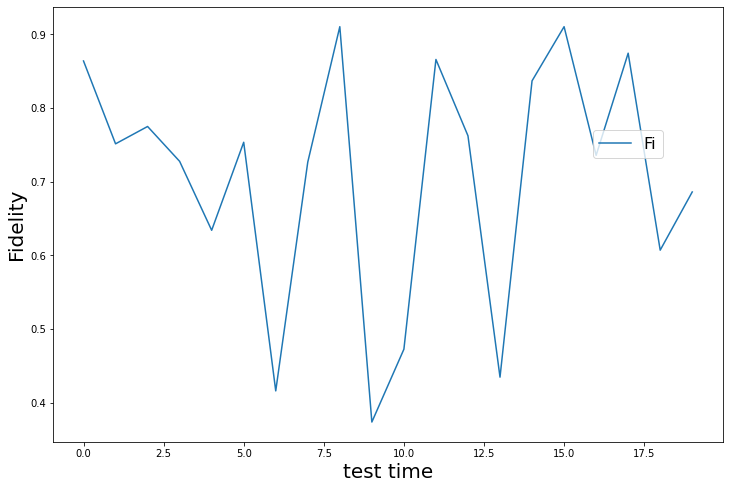

In [9]:
fig, ax1 = plt.subplots(figsize=(12,8))
ax1.plot(diffevo.data_fidelity, label="Fi")

ax1.set_xlabel("test time", fontsize=20) 
ax1.set_ylabel("Fidelity", fontsize=20)

fig.legend(bbox_to_anchor=(.84, .68), fontsize=16)

In [10]:
testnpy = np.load("out.npz")

In [11]:
print(diffevo.op_pulse)

{'Omega1': [35.28197207198431, 10.257204747946531, 70.6389419550396, 16.72346564265142, 31.851647736172666, -86.54325764540572], 'Omega2': [181.52774019659682, 156.15935216874206, 178.5096985007964, 173.66633330829302, 188.3916006887909, 172.61835866982017], 'Delta1': [365.32672698618535, 389.2590045859555, 379.3979511403668, 390.175897126288, 360.148610253748, 396.5497366056936]}


In [12]:
# Pulse shape
T_gate = 1          # (mu s) Total gate time
n = 12   # Number of segments
dt = T_gate/n       # (mu s) Duration of each segment
def Pshape(t, pulse_coe):
        ith = int( (t - dt/2) // dt )
        ti = dt/2 + dt*ith
        ti1 = ti + dt
        
        if t < dt/2 or t > (T_gate - dt/2):
            fi = pulse_coe[0]
            fi1 = pulse_coe[0]
            ft = (fi + fi1)/2 

        else:
            if ith < 5:
                ith1 = ith + 1
                fi = pulse_coe[ith]
                fi1 = pulse_coe[ith1]
                ft = ( (fi + fi1)/2 + ( (fi1-fi)/2 ) * math.erf( (5/dt) * ( t - (ti + ti1)/2 ) ) )

            elif ith == 5:
                ith1 = ith
                fi = pulse_coe[ith]
                fi1 = pulse_coe[ith1]
                ft = ( (fi + fi1)/2 + ( (fi1-fi)/2 ) * math.erf( (5/dt) * ( t - (ti + ti1)/2 ) ) )

            elif ith > 5:
                ith1 = ith + 1
                fi = pulse_coe[n-ith-1]
                fi1 = pulse_coe[n-ith1-1]
                ft  = ( (fi + fi1)/2 + ( (fi1-fi)/2 ) * math.erf( (5/dt) * ( t - (ti + ti1)/2 ) ) )

        return ft

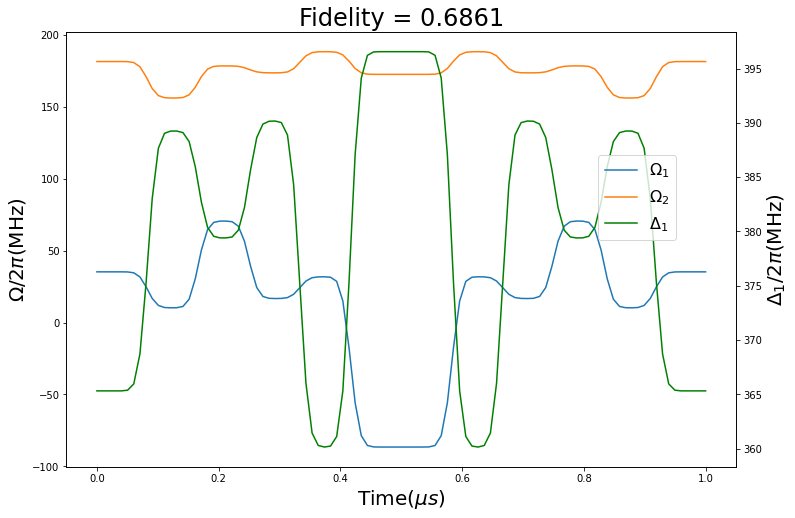

In [13]:
Omega1 = diffevo.op_pulse['Omega1']
Omega2 = diffevo.op_pulse['Omega2']
Delta1 = diffevo.op_pulse['Delta1']
times = np.linspace(0.0, 1, 100)

pulse_Omega1 = []
pulse_Omega2 = []
delta1 = []

for t in times:
    pulse_Omega1.append( Pshape(t, Omega1))
    pulse_Omega2.append( Pshape(t, Omega2))
    delta1.append( Pshape(t, Delta1))

fig, ax1 = plt.subplots(figsize=(12,8))
ax1.plot(times, pulse_Omega1, label=r'$\Omega_1$')
ax1.plot(times, pulse_Omega2, label=r'$\Omega_2$')
ax2 = ax1.twinx()
ax2.plot(times, delta1, 'g', label=r'$\Delta_1$')

ax1.set_xlabel('Time' r'$(\mu s)$', fontsize=20) 
ax1.set_ylabel(r'$\Omega / 2 \pi$' '(MHz)', fontsize=20)
ax2.set_ylabel(r'$\Delta_1 / 2 \pi$' '(MHz)', fontsize=20)

plt.title("Fidelity = %.4f" %diffevo.op_fidelity, fontsize=24)
fig.legend(bbox_to_anchor=(.84, .68), fontsize=16)
# ax1.legend(fontsize=16)
# ax2.legend(fontsize=16)